In [5]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import shutil
import tensorflow as tf
import keras

In [2]:
# data_dir = 'garbage-split'
# categories  = ['battery', 'biodegradable', 'cardboard', 'glass', 'paper', 'metal', 'plastic']
# data = []
# data_labels = []

# for categorie in categories :
#     folder_path = os.path.join(data_dir, categorie)
#     image_paths = os.listdir(folder_path)
#     data.extend([os.path.join(folder_path, image_path) for image_path in image_paths])
#     data_labels.extend([categorie] * len(image_paths))
# data = pd.DataFrame({'Image_Path' : data, 'labels' : data_labels})
# data

In [3]:
# labels = ['battery', 'biodegradable', 'cardboard', 'glass', 'paper', 'metal', 'plastic']

# for label in labels:
#     sample_images = data[data['labels'] == label]['Image_Path'].reset_index(drop=True)[:5]

#     print(f"Displaying Some Sample images of '{label}' categorie : ")
#     # Displaying Some Sample images in RGB
#     plt.figure(figsize=(20, 8))
#     for i in range(len(sample_images)):
#         plt.subplot(2, 5, i + 1 + 5)
#         img = cv2.imread(sample_images[i])
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         plt.imshow(img)
#         plt.title(label, fontsize=9)
#         plt.axis('off')
        
#     plt.show()

splitting train, test, val folders

In [4]:
# data_dir = 'garbage-dataset'
# output_dir = 'garbage-split'
# train_dir = os.path.join(output_dir, 'train')
# test_dir = os.path.join(output_dir, 'test')
# val_dir = os.path.join(output_dir, 'val')

# for directory in [train_dir, test_dir, val_dir]:
#     os.makedirs(directory, exist_ok=True)

# categories = ['battery', 'biodegradable', 'cardboard', 'glass', 'paper', 'metal', 'plastic']

# train_ratio = 0.8
# test_ratio = 0.1
# val_ratio = 0.1

# for category in categories:
#     category_path = os.path.join(data_dir, category)
#     images = os.listdir(category_path)
#     np.random.shuffle(images) 

#     train_split = int(len(images) * train_ratio)
#     test_split = int(len(images) * test_ratio)
    
#     train_images = images[:train_split]
#     test_images = images[train_split:train_split + test_split]
#     val_images = images[train_split + test_split:]

#     for dataset, image_list in zip([train_dir, test_dir, val_dir], [train_images, test_images, val_images]):
#         category_output_path = os.path.join(dataset, category)
#         os.makedirs(category_output_path, exist_ok=True)

#         for image in image_list:
#             src = os.path.join(category_path, image)
#             dst = os.path.join(category_output_path, image)
#             shutil.copy(src, dst)

#     print(f"Processed {category}: {len(train_images)} train, {len(test_images)} test, {len(val_images)} val images.")

# print("Dataset successfully split into train, test, and validation sets!")


Preprocess and save data

In [5]:
# from tensorflow.keras.preprocessing.image import load_img, img_to_array

# # Define paths
# dataset_dir = "garbage-split"  
# output_dir = "preprocessed_data" 

# categories = ['battery', 'biodegradable', 'cardboard', 'glass', 'paper', 'metal', 'plastic']
# IMG_SIZE = (224, 224)
# for split in ['train', 'test', 'val']:
#     split_dir = os.path.join(dataset_dir, split)
#     output_split_dir = os.path.join(output_dir, split)
#     os.makedirs(output_split_dir, exist_ok=True)  # Create output folder if it doesn't exist

#     for category in categories:
#         category_dir = os.path.join(split_dir, category)
#         output_category_dir = os.path.join(output_split_dir, category)
#         os.makedirs(output_category_dir, exist_ok=True)  # Create category subfolder

#         for img_name in os.listdir(category_dir):
#             img_path = os.path.join(category_dir, img_name)
#             try:
  
#                 img = load_img(img_path, target_size=IMG_SIZE)  
#                 img_array = img_to_array(img) / 255.0 

#                 np.save(os.path.join(output_category_dir, img_name.replace('.jpg', '.npy')), img_array)
            
#             except Exception as e:
#                 print(f"Error processing {img_path}: {e}")

#     print(f"Saved preprocessed images for {split}")


Dynamically load pre-processed images

In [6]:
class GarbageDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data_dir, batch_size=32, img_size=(224, 224), shuffle=True):
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.categories = sorted(os.listdir(data_dir))  # Get category names
        self.file_paths, self.labels = self._load_file_paths()
        self.indexes = np.arange(len(self.file_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def _load_file_paths(self):
        """Get all .npy file paths and their corresponding labels"""
        file_paths = []
        labels = []
        for label_idx, category in enumerate(self.categories):
            category_path = os.path.join(self.data_dir, category)
            for file_name in os.listdir(category_path):
                if file_name.endswith('.npy'):
                    file_paths.append(os.path.join(category_path, file_name))
                    labels.append(label_idx)  # Assign numeric label

        return file_paths, np.array(labels)

    def __len__(self):
        """Return total number of batches"""
        return int(np.ceil(len(self.file_paths) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data"""
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_paths = [self.file_paths[i] for i in batch_indexes]
        batch_labels = [self.labels[i] for i in batch_indexes]

        X = np.array([np.load(path) for path in batch_paths], dtype=np.float32)
        y = np.array(batch_labels)

        return X, tf.keras.utils.to_categorical(y, num_classes=len(self.categories))

    def on_epoch_end(self):
        """Shuffle data at end of epoch"""
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [7]:
train_dir = "preprocessed_data/train"
val_dir = "preprocessed_data/val"
test_dir = "preprocessed_data/test"

BATCH_SIZE = 32  

train_generator = GarbageDataGenerator(train_dir, batch_size=BATCH_SIZE)
val_generator = GarbageDataGenerator(val_dir, batch_size=BATCH_SIZE)
test_generator = GarbageDataGenerator(test_dir, batch_size=BATCH_SIZE, shuffle=False)

X_batch, y_batch = train_generator[0]
print(f"Batch shape: {X_batch.shape}, Labels shape: {y_batch.shape}")


Batch shape: (32, 224, 224, 3), Labels shape: (32, 7)


Visualize random preprocessed data

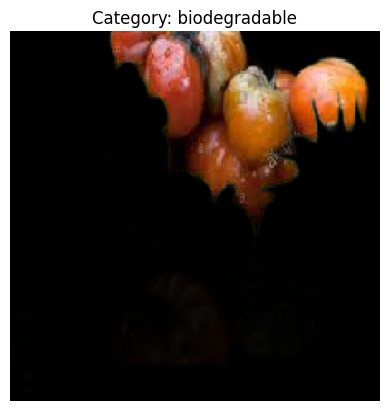

In [8]:
preprocessed_dir = "preprocessed_data/train"  # Change to 'val' or 'test' if needed
categories = os.listdir(preprocessed_dir)  

category = np.random.choice(categories)
category_path = os.path.join(preprocessed_dir, category)
image_file = np.random.choice(os.listdir(category_path))

image_path = os.path.join(category_path, image_file)
image = np.load(image_path)  # Shape: (224, 224, 3)

plt.imshow(image)
plt.title(f"Category: {category}")
plt.axis("off")
plt.show()

Build Model

In [9]:
from keras.models import Sequential
from keras.layers import  Conv2D, Flatten, Dense, Dropout, MaxPooling2D

In [10]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout

seq_model2 = Sequential(name="Alternative_CNN_Model")

seq_model2.add(Conv2D(32, (3, 3), activation="relu", input_shape=(224, 224, 3), name="Conv2d_input_layer"))
seq_model2.add(MaxPooling2D((2, 2), name="maxpooling_1"))

seq_model2.add(Conv2D(64, (3, 3), activation="relu", name="Conv2dlayer_2"))
seq_model2.add(MaxPooling2D((2, 2), name="maxpooling_2"))

seq_model2.add(Conv2D(128, (3, 3), activation="relu", name="Conv2dlayer_3"))
seq_model2.add(MaxPooling2D((2, 2), name="maxpooling_3"))

seq_model2.add(GlobalAveragePooling2D(name="GlobalAvgPoolingLayer"))

seq_model2.add(Dense(256, activation="relu", name="Denselayer"))
seq_model2.add(Dropout(0.5, name="Dropoutlayer"))

seq_model2.add(Dense(7, activation="softmax", name="output_layer"))

seq_model2.summary()


seq_model2.compile(
    optimizer= 'adam',
    loss="categorical_crossentropy", 
    metrics=["accuracy"]
)

c:\Users\Dell\anaconda3\envs\dl-workshop\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Alternative_CNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv2d_input_layer (Conv2D)     │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpooling_1 (MaxPooling2D)     │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2dlayer_2 (Conv2D)          │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpooling_2 (MaxPooling2D)     │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2dlayer_3 (Conv2D)          │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpooling_3 (MaxPooling2D)     │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ GlobalAvgPoolingLayer           │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Denselayer (Dense)              │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropoutlayer (Dropout)          │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,071 (500.28 KB)

 Trainable params: 128,071 (500.28 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model2 = seq_model2.fit(train_generator, validation_data=val_generator, batch_size=32, epochs=10)

c:\Users\Dell\anaconda3\envs\dl-workshop\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 462s 2s/step - accuracy: 0.2201 - loss: 1.8516 - val_accuracy: 0.3750 - val_loss: 1.6151
Epoch 2/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 240s 909ms/step - accuracy: 0.3965 - loss: 1.5972 - val_accuracy: 0.4552 - val_loss: 1.4682
Epoch 3/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 207s 786ms/step - accuracy: 0.4495 - loss: 1.4839 - val_accuracy: 0.4771 - val_loss: 1.4012
Epoch 4/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 210s 799ms/step - accuracy: 0.4952 - loss: 1.3766 - val_accuracy: 0.5439 - val_loss: 1.2891
Epoch 5/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 209s 798ms/step - accuracy: 0.5417 - loss: 1.2821 - val_accuracy: 0.5553 - val_loss: 1.2882
Epoch 6/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 213s 812ms/step - accuracy: 0.5535 - loss: 1.2466 - val_accuracy: 0.5821 - val_loss: 1.2108
Epoch 7/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 245s 932ms/step - accuracy: 0.5626 - loss: 1.2037 - val_accuracy: 0.5592 - val_loss: 1.2237
Epoch 8/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 206s 780ms/step - accuracy: 0.5632 - lo

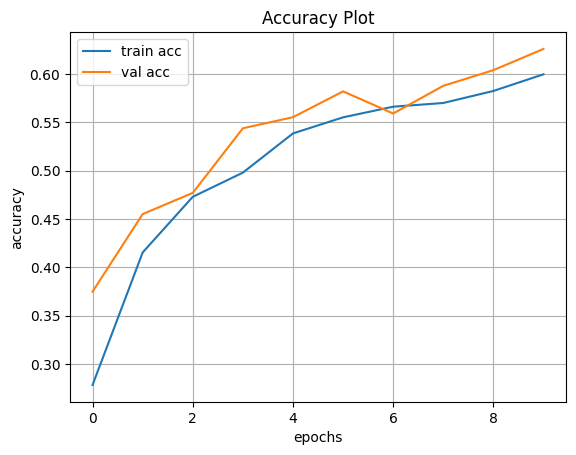

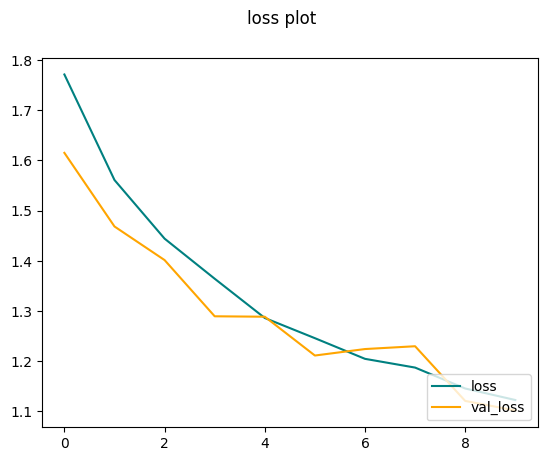

In [12]:
plt.plot(model2.history['accuracy'], label="train acc")
plt.plot(model2.history['val_accuracy'], label="val acc")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Accuracy Plot")
plt.legend()
plt.grid()
plt.show()

fig = plt.figure()
plt.plot(model2.history['loss'], color='teal', label='loss')
plt.plot(model2.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('loss plot')
plt.legend(loc= "lower right")
plt.show()

In [16]:
seq_model2.save("garbageclassification2.keras")

Model3

In [27]:
seq_model3 = Sequential(name="Optimized_CNN_Model")

seq_model3.add(Conv2D(32, (3, 3), activation="relu", input_shape=(224, 224, 3), name="Conv2D_layer1"))
seq_model3.add(MaxPooling2D((2, 2), name="MaxPooling1"))

seq_model3.add(Conv2D(64, (3, 3), activation="relu", name="Conv2D_layer2"))
seq_model3.add(MaxPooling2D((2, 2), name="MaxPooling2"))

seq_model3.add(Conv2D(128, (3, 3), activation="relu", name="Conv2D_layer3"))
seq_model3.add(MaxPooling2D((2, 2), name="MaxPooling3"))

seq_model3.add(Conv2D(256, (3, 3), activation="relu", name="Conv2D_layer4"))
seq_model3.add(MaxPooling2D((2, 2), name="MaxPooling4"))

seq_model3.add(Flatten(name="Flatten_layer"))

seq_model3.add(Dense(512, activation="relu", name="Dense_layer1"))
seq_model3.add(Dropout(0.5, name="Dropout1"))

seq_model3.add(Dense(7, activation="softmax", name="Output_layer"))

seq_model3.summary()

seq_model3.compile(
    optimizer= 'adam',
    loss="categorical_crossentropy", 
    metrics=["accuracy"]
)

c:\Users\Dell\anaconda3\envs\dl-workshop\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Optimized_CNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv2D_layer1 (Conv2D)          │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling1 (MaxPooling2D)      │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_layer2 (Conv2D)          │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling2 (MaxPooling2D)      │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_layer3 (Conv2D)          │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling3 (MaxPooling2D)      │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_layer4 (Conv2D)          │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling4 (MaxPooling2D)      │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten_layer (Flatten)         │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_layer1 (Dense)            │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout1 (Dropout)              │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_layer (Dense)            │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,266,887 (73.50 MB)

 Trainable params: 19,266,887 (73.50 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
model3 = seq_model3.fit(train_generator, validation_data=val_generator, batch_size=32, epochs=10)

Epoch 1/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 519s 2s/step - accuracy: 0.2932 - loss: 1.8436 - val_accuracy: 0.4847 - val_loss: 1.2997
Epoch 2/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 313s 1s/step - accuracy: 0.5262 - loss: 1.2823 - val_accuracy: 0.6097 - val_loss: 1.0784
Epoch 3/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 1220s 5s/step - accuracy: 0.6177 - loss: 1.0791 - val_accuracy: 0.6393 - val_loss: 0.9755
Epoch 4/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 316s 1s/step - accuracy: 0.6773 - loss: 0.9040 - val_accuracy: 0.6994 - val_loss: 0.8846
Epoch 5/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 313s 1s/step - accuracy: 0.7442 - loss: 0.7283 - val_accuracy: 0.7080 - val_loss: 0.8681
Epoch 6/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 322s 1s/step - accuracy: 0.7876 - loss: 0.5921 - val_accuracy: 0.7090 - val_loss: 0.9209
Epoch 7/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 320s 1s/step - accuracy: 0.8472 - loss: 0.4332 - val_accuracy: 0.7281 - val_loss: 0.9122
Epoch 8/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 387s 1s/step - accuracy: 0.8807 - loss: 0.3401 - val_acc

In [29]:
test_loss, test_acc = seq_model3.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

33/33 ━━━━━━━━━━━━━━━━━━━━ 29s 861ms/step - accuracy: 0.7644 - loss: 1.0341
Test Accuracy: 74.69%


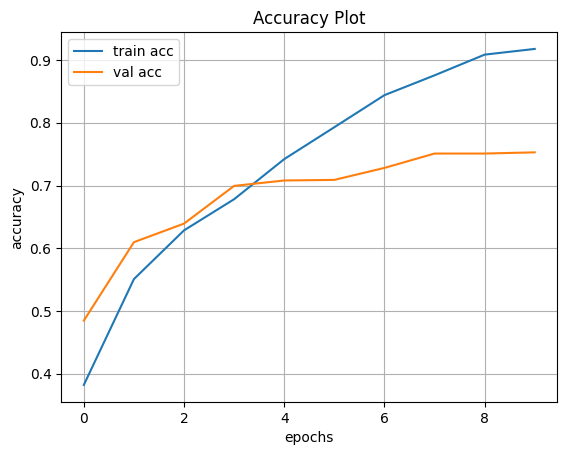

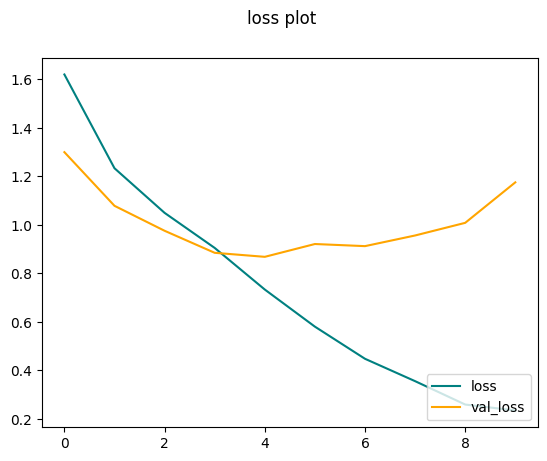

In [30]:
plt.plot(model3.history['accuracy'], label="train acc")
plt.plot(model3.history['val_accuracy'], label="val acc")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Accuracy Plot")
plt.legend()
plt.grid()
plt.show()

fig = plt.figure()
plt.plot(model3.history['loss'], color='teal', label='loss')
plt.plot(model3.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('loss plot')
plt.legend(loc= "lower right")
plt.show()

In [31]:
seq_model3.save("garbageclassification3.keras")

Model 4

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

seq_model4 = Sequential(name="model4_CNN")

# Convolutional Layers
seq_model4.add(Conv2D(32, (3, 3), activation="relu", input_shape=(224, 224, 3), name="Conv2D_layer1"))
seq_model4.add(BatchNormalization(name="BatchNorm1"))
seq_model4.add(MaxPooling2D((2, 2), name="MaxPooling1"))

seq_model4.add(Conv2D(64, (3, 3), activation="relu", name="Conv2D_layer2"))
seq_model4.add(BatchNormalization(name="BatchNorm2"))
seq_model4.add(MaxPooling2D((2, 2), name="MaxPooling2"))

seq_model4.add(Conv2D(128, (3, 3), activation="relu", name="Conv2D_layer3"))
seq_model4.add(BatchNormalization(name="BatchNorm3"))
seq_model4.add(MaxPooling2D((2, 2), name="MaxPooling3"))

seq_model4.add(Conv2D(256, (3, 3), activation="relu", name="Conv2D_layer4"))
seq_model4.add(BatchNormalization(name="BatchNorm4"))
seq_model4.add(MaxPooling2D((2, 2), name="MaxPooling4"))

seq_model4.add(GlobalAveragePooling2D(name="GlobalAvgPool"))

seq_model4.add(Dense(512, activation="relu", name="Dense_layer1"))
seq_model4.add(Dropout(0.6, name="Dropout1"))

seq_model4.add(Dense(7, activation="softmax", name="Output_layer"))

optimizer = Adam(learning_rate=0.0001)
seq_model4.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

seq_model4.summary()


c:\Users\Dell\anaconda3\envs\dl-workshop\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "model4_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv2D_layer1 (Conv2D)          │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNorm1 (BatchNormalization) │ (None, 222, 222, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling1 (MaxPooling2D)      │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_layer2 (Conv2D)          │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNorm2 (BatchNormalization) │ (None, 109, 109, 64)   │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling2 (MaxPooling2D)      │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_layer3 (Conv2D)          │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNorm3 (BatchNormalization) │ (None, 52, 52, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling3 (MaxPooling2D)      │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_layer4 (Conv2D)          │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNorm4 (BatchNormalization) │ (None, 24, 24, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling4 (MaxPooling2D)      │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ GlobalAvgPool                   │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_layer1 (Dense)            │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout1 (Dropout)              │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_layer (Dense)            │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 525,511 (2.00 MB)

 Trainable params: 524,551 (2.00 MB)

 Non-trainable params: 960 (3.75 KB)

In [5]:
! pip install pydot

In [7]:
import keras
keras.utils.plot_model(seq_model4)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [35]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('model4.keras', monitor='val_accuracy', save_best_only=True)

callbacks = [early_stopping, reduce_lr, model_checkpoint]

In [36]:
model4 = seq_model4.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 1439s 5s/step - accuracy: 0.3764 - loss: 1.6894 - val_accuracy: 0.2739 - val_loss: 1.8559 - learning_rate: 1.0000e-04
Epoch 2/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 778s 3s/step - accuracy: 0.5318 - loss: 1.2864 - val_accuracy: 0.4370 - val_loss: 1.4313 - learning_rate: 1.0000e-04
Epoch 3/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 972s 4s/step - accuracy: 0.5696 - loss: 1.1992 - val_accuracy: 0.5802 - val_loss: 1.1519 - learning_rate: 1.0000e-04
Epoch 4/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 869s 3s/step - accuracy: 0.6117 - loss: 1.0880 - val_accuracy: 0.6279 - val_loss: 1.0529 - learning_rate: 1.0000e-04
Epoch 5/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 734s 3s/step - accuracy: 0.6471 - loss: 0.9974 - val_accuracy: 0.6116 - val_loss: 1.1117 - learning_rate: 1.0000e-04
Epoch 6/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 817s 3s/step - accuracy: 0.6473 - loss: 0.9752 - val_accuracy: 0.6365 - val_loss: 1.0359 - learning_rate: 1.0000e-04
Epoch 7/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 743s 3s/step - ac

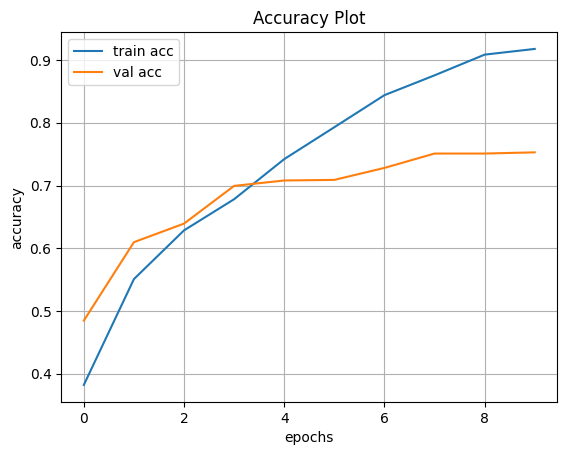

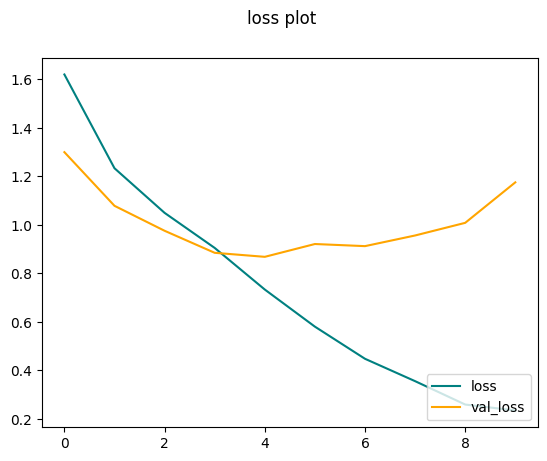

In [37]:
plt.plot(model3.history['accuracy'], label="train acc")
plt.plot(model3.history['val_accuracy'], label="val acc")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Accuracy Plot")
plt.legend()
plt.grid()
plt.show()

fig = plt.figure()
plt.plot(model3.history['loss'], color='teal', label='loss')
plt.plot(model3.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('loss plot')
plt.legend(loc= "lower right")
plt.show()

Confusion Matrix

In [7]:
from sklearn.metrics import classification_report, confusion_matrix

Load pretrained model

In [4]:
from tensorflow.keras.models import load_model
model = load_model("model4.keras") 

c:\Users\Dell\anaconda3\envs\dl-workshop\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 720ms/step

Test Classification Report:
               precision    recall  f1-score   support

      battery       0.15      0.15      0.15        95
biodegradable       0.08      0.09      0.09       101
    cardboard       0.12      0.11      0.11       183
        glass       0.20      0.20      0.20       200
        metal       0.08      0.07      0.07       102
        paper       0.16      0.16      0.16       168
      plastic       0.18      0.19      0.18       199

     accuracy                           0.15      1048
    macro avg       0.14      0.14      0.14      1048
 weighted avg       0.15      0.15      0.15      1048



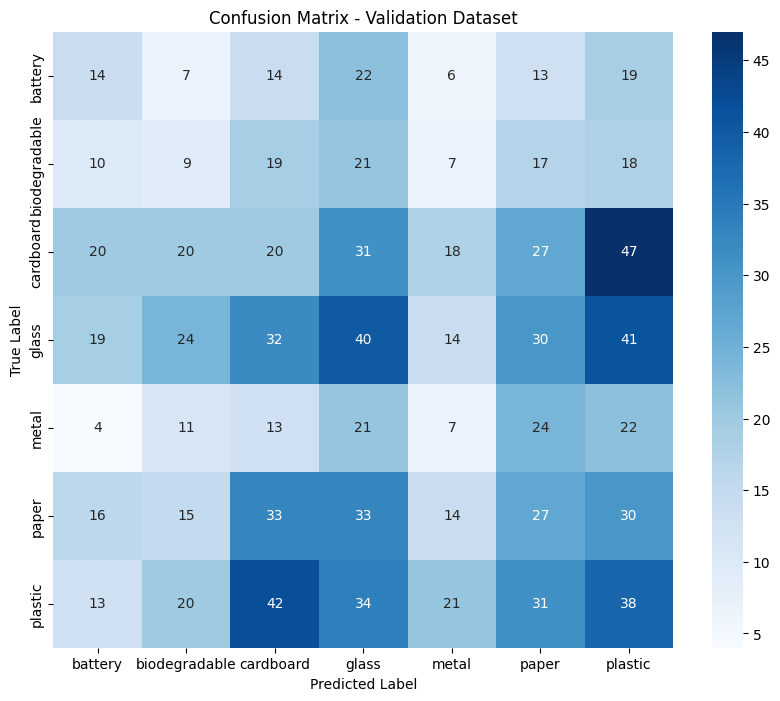

In [5]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get class names from generator
class_names = list(val_generator.categories)

# Predict on validation data
val_predictions = model.predict(val_generator)
y_pred = np.argmax(val_predictions, axis=1)  # Get predicted labels

# Extract true labels without concatenating large arrays
y_true = []
for i in range(len(val_generator)):
    _, labels = val_generator[i]  # Get labels batch-wise
    y_true.extend(np.argmax(labels, axis=1))  # Convert one-hot to class index

y_true = np.array(y_true)  # Convert list to array

# Print classification report
print("\nTest Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Validation Dataset')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


Preprocessing input img

In [8]:
def preprocess_image(image_path, target_size=(224, 224), save_npy=False, npy_path=None):
    img = cv2.imread(image_path)  
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
    img = cv2.resize(img, target_size)  
    img = img_to_array(img) / 255.0  
    img = np.expand_dims(img, axis=0)  
    
    # Save as .npy if required
    if save_npy and npy_path:
        np.save(npy_path, img)
    
    return img

Predict

In [9]:
def predict_image(image_path, model, class_labels):
    img = np.load(image_path)  
    img = np.expand_dims(img, axis=0) 
    print("Image shape before prediction:", img.shape)  
    img = img.reshape((1, 224, 224, 3))
 

    prediction = model.predict(img) 
    predicted_class = np.argmax(prediction) 

    print(f"Predicted Class: {class_labels[predicted_class]}")
    return class_labels[predicted_class]

garbage_generator = GarbageDataGenerator(data_dir="garbage-split/test")

class_labels = garbage_generator.categories

image_path = "preprocessed_data/test/metal/metal_729.npy"

predicted_class = predict_image(image_path, model, class_labels)


Image shape before prediction: (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
Predicted Class: plastic
